## Worflow
- Set network parameters
- Optimize for twiddle bits
- Collect training and validation data
- Train for wiggly function
- Validate training

Fixed parameters:
- number of neurons

Swept parameters:
- function wiggliness
- fmax

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
from nengo_brainstorm.solvers import CVXSolver
from nengo_extras.plot_spikes import plot_spikes

import pystorm
from pystorm.hal import HAL
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal.data_utils import lpf, bin_to_spk_times, bins_to_rates

import utils

In [2]:
# fixed parameters
# network parameters
X = 32
Y = 32
NNEURON = X*Y
DIM = 1

DATA_DIR = "data/test_accumulator_decodes/"
FIG_DIR = "figures/test_accumulator_decodes/"

# experimental parameters
TRAINING_DOWNSTREAM_NS = 10000 # minimum time resolution, downstream time resolution
TRAINING_UPSTREAM_NS   = 1000000 # default upstream time resolution
FMAX_IN = 1000
TUNING_INPUT_POINTS = 321 # number of input points to take for collecting tuning data
TUNING_POINT_TIME_NS = int(2*1E9) # time to record data per tuning curve input point
VALIDATION_SKIP = 5 # reserve every VALIDATION_SKIP points from tuning data for validation
TEST_INPUT_POINTS = 61 # number of input points to take for validating fit
TEST_POINT_TIME_NS = int(0.5*1E9) # time to collect data for each testing point
TESTING_DOWNSTREAM_NS = 1000 # downstream time resolution for testing
TESTING_UPSTREAM_NS = 1000 # upstream time resolution for testing
TESTING_RAW_SPIKES_DOWNSTREAM_NS = 1000 # downstream time resolution for collecting raw spikes for testing
TESTING_RAW_SPIKES_UPSTREAM_NS = 10000 # downstream time resolution for collecting raw spikes for testing
CLIP_TIME = 0.2 # how much of the initial data to discard during testing
TAU_READOUT = 0.01 # synaptic readout time constant
FSCALE = 1000.
REG_L2 = .1
REG_L1 = .1

PS_ORIG = PoolSpec(
    label = "pool",
    YX = (Y, X),
    loc_yx = (0, 0),
    D = DIM,
)

def FCN(x, f):
    """Base function used in testing"""
    return 0.5 + 0.5*np.sin(np.pi*f*x)
    
# swept parameters
# FMAX_OUTS = [1500, 1000, 500]
FMAX_OUTS = [2000, 1500, 1000]
# FMAX_OUTS = [4000, 2000, 1000]
FCN_F = [0.5, 1., 1.5, 2.0]

In [3]:
def sweep_inputs_collect_spikes(
        net, hal, run_control,
        input_points, fmax_in, time_per_point_ns, fname_pre_cache):
    """Collect tuning data to be used when fitting decoders"""
    time_points_ns = np.arange(input_points+1)*time_per_point_ns
    input_rates = np.zeros((input_points+1, 1))
    input_rates[:input_points, 0] = fmax_in * np.linspace(-1, 1, input_points)
    input_rates[-1, 0] = input_rates[-2, 0]
    input_data = {net.input:(time_points_ns, input_rates)}

    fname_cache = (
        DATA_DIR + fname_pre_cache + "_" + str(PS_ORIG.YX) + "_" +
        str(PS_ORIG.loc_yx) + "_" + str(input_points) + "_" + str(time_per_point_ns) + ".pck")
    def sweep_fun():
        _, spike_data = run_control.run_input_sweep(
            input_data, get_raw_spikes=True, get_outputs=False)
        spikes, bin_times_ns = spike_data
        spikes = spikes[net.pool]    
        spike_rates = bins_to_rates(spikes, bin_times_ns,
                                    time_points_ns, init_discard_frac=0.25)
        return spike_rates
    spike_rates = utils.cache_fun(fname_cache, sweep_fun)
    return input_rates[:-1], spike_rates

def sweep_inputs_collect_decodes(
        net, hal, run_control,
        input_points, fmax_in, time_per_point_ns, fname_pre_cache, decoders=None):
    """Collect decode data to test decoders"""
    time_points_ns = np.arange(input_points+1)*time_per_point_ns
    input_rates = np.zeros((input_points+1, 1))
    input_rates[:input_points, 0] = fmax_in * np.linspace(-1, 1, input_points)
    input_rates[-1, 0] = input_rates[-2, 0]
    input_data = {net.input:(time_points_ns, input_rates)}

    fname_cache = (
        DATA_DIR + fname_pre_cache + "_" + str(PS_ORIG.YX) + "_" +
        str(PS_ORIG.loc_yx) + "_" + str(input_points) + "_" + str(time_per_point_ns) + ".pck")
    def sweep_fun():
        if decoders is not None:
            net.decoder_conn.reassign_weights(decoders)
            hal.remap_weights()
        output_data, _ = run_control.run_input_sweep(
            input_data, get_raw_spikes=False, get_outputs=True)
        outputs, bin_times_ns = output_data
        outputs = outputs[net.output][:, 0].reshape((-1, 1))
        output_rates = bins_to_rates(outputs, bin_times_ns,
                                     time_points_ns, init_discard_frac=0.25)
        return output_rates
    output_rates = utils.cache_fun(fname_cache, sweep_fun)
    return input_rates[:-1], output_rates

class ExpData:
    def __init__(self, fmax_in, fmax_outs, fcn_fs):
        self.fmax_in = fmax_in
        self.fmax_outs = fmax_outs
        self.fcn_fs = fcn_fs

    def collect_tuning_data(self, net, hal, run_control,
                            input_points, time_per_point_ns):
        """Collect tuning data to be used when fitting decoders"""
        hal.set_time_resolution(TRAINING_DOWNSTREAM_NS, TRAINING_UPSTREAM_NS)
        self.tuning_input_rates, self.tuning_spike_rates = sweep_inputs_collect_spikes(
            net, hal, run_control, input_points, self.fmax_in, time_per_point_ns, "tuning")
        
    def split_tuning_data(self, valid_skip):
        """split into training and validation sets"""
        input_points = len(self.tuning_input_rates)
        start_idx = valid_skip//2
        t_idx = np.ones(input_points, dtype=bool)
        t_idx[start_idx::valid_skip] = False
        v_idx = ~t_idx
        self.training_input_rates = self.tuning_input_rates[t_idx]
        self.training_spike_rates = self.tuning_spike_rates[t_idx]
        self.validation_input_rates = self.tuning_input_rates[v_idx]
        self.validation_spike_rates = self.tuning_spike_rates[v_idx]

    def plot_tuning(self, array_width, array_height):
        inputs = self.tuning_input_rates
        spike_rates = self.tuning_spike_rates
        t_inputs = self.training_input_rates
        t_spike_rates = self.training_spike_rates
        v_inputs = self.validation_input_rates
        v_spike_rates = self.validation_spike_rates

        fig, (ax_all, ax_t, ax_v) = plt.subplots(ncols=3, figsize=(14, 4), sharex=True)

        half_width = array_width//2
        for idx in range(array_height):
            start_l = idx*array_width
            start_r = start_l + half_width
            ax_all.plot(inputs, spike_rates[:, start_l:start_l+half_width], 'r')
            ax_all.plot(inputs, spike_rates[:, start_r:start_r+half_width], 'b')

            ax_t.plot(t_inputs, t_spike_rates[:, start_l:start_l+half_width], 'r-o')
            ax_t.plot(t_inputs, t_spike_rates[:, start_r:start_r+half_width], 'b-o')    
            ax_v.plot(v_inputs, v_spike_rates[:, start_l:start_l+half_width], 'r-o')
            ax_v.plot(v_inputs, v_spike_rates[:, start_r:start_r+half_width], 'b-o')    
        ax_all.set_title("All tuning data")
        ax_t.set_title("Training tuning data")
        ax_v.set_title("Validation tuning data")
        fig.savefig(FIG_DIR + "tuning" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + "_"  + str(TUNING_INPUT_POINTS) + "_" + str(TUNING_POINT_TIME_NS) + ".png")

EXP_DATA = ExpData(FMAX_IN, FMAX_OUTS, FCN_F)

In [4]:
hal = pystorm.hal.HAL()
net_builder = NetBuilder(hal)
calibrator = Calibrator(hal)

/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:724: RuntimeWarning: invalid value encountered in less
  good_mask = (intercepts < 1) & (intercepts > -1)
/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:724: RuntimeWarning: invalid value encountered in greater
  good_mask = (intercepts < 1) & (intercepts > -1)


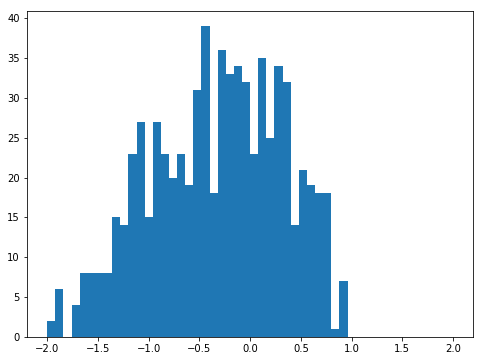

In [5]:
def build_net(ps_orig, net_builder, calibrator):
    d_matrix = np.zeros((2, Y*X))    
    p_fname = (DATA_DIR + ps_orig.label + "_" + str(ps_orig.YX) + "_" +
               str(ps_orig.loc_yx) + "_" + str(ps_orig.D) + ".pck")
    ps, est_enc, est_off = utils.optimize_yield_w_cache(ps_orig, p_fname, calibrator)
    intercepts, good_mask = calibrator.get_intercepts(est_enc, est_off)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(intercepts[~np.isnan(intercepts)], bins=50, range=(-2, 2))
    fig.savefig(FIG_DIR + "intercepts" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + "_"  + str(TUNING_INPUT_POINTS) + "_" + str(TUNING_POINT_TIME_NS) + ".png")

    # add yield plot
    net = net_builder.create_single_pool_net_from_spec(ps, d_matrix)
    return net

net = build_net(PS_ORIG, net_builder, calibrator)
run_control = RunControl(hal, net)
hal.map(net)

# Collect Tuning Data

- Check that tuning curves look reasonable

In [6]:
EXP_DATA.collect_tuning_data(
    net, hal, run_control, TUNING_INPUT_POINTS, TUNING_POINT_TIME_NS)

In [7]:
EXP_DATA.split_tuning_data(VALIDATION_SKIP)

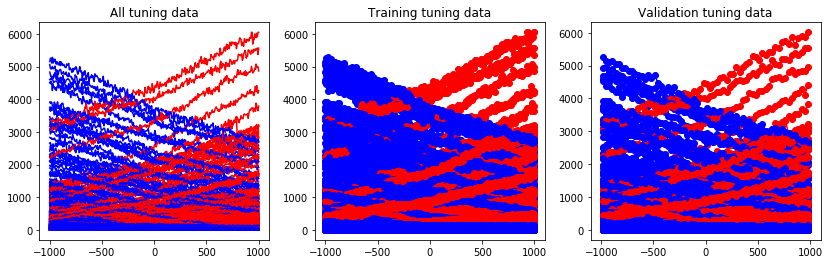

In [8]:
EXP_DATA.plot_tuning(X, Y)

# Train, Validate, Test Decoders

In [9]:
def fit_decoders(rates, target_function):
    solver = CVXSolver(reg=REG_L2, reg_l1=REG_L1)
    decoders, info = solver(rates/FSCALE, target_function/FSCALE)
    decoders = decoders.clip(-1, 1)
    return decoders, info

def run_fits(exp_data):
    exp_data.decoders = []
    exp_data.training_targets = []
    t_input = exp_data.training_input_rates/exp_data.fmax_in
    for fmax_out in exp_data.fmax_outs:
        exp_data.training_targets += [[]]
        exp_data.decoders += [[]]
        for fcn_f in exp_data.fcn_fs:
            t_targets = fmax_out * FCN(
                t_input, fcn_f) 
            print("Solving for fmax_out {:.0f} fcn_f {:.1f}".format(fmax_out, fcn_f))
            decoders, info = fit_decoders(
                exp_data.training_spike_rates, t_targets)
            exp_data.training_targets[-1] += [t_targets]
            exp_data.decoders[-1] += [decoders]
    exp_data.training_input = t_input

run_fits(EXP_DATA)

Solving for fmax_out 2000 fcn_f 0.5
Solving for fmax_out 2000 fcn_f 1.0
Solving for fmax_out 2000 fcn_f 1.5
Solving for fmax_out 2000 fcn_f 2.0
Solving for fmax_out 1500 fcn_f 0.5
Solving for fmax_out 1500 fcn_f 1.0
Solving for fmax_out 1500 fcn_f 1.5
Solving for fmax_out 1500 fcn_f 2.0
Solving for fmax_out 1000 fcn_f 0.5
Solving for fmax_out 1000 fcn_f 1.0
Solving for fmax_out 1000 fcn_f 1.5
Solving for fmax_out 1000 fcn_f 2.0


In [10]:
def test_decoders(exp_data, time_per_point_ns):
    exp_data.test_input_rates = None
    exp_data.test_output_rates = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.test_output_rates += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            print("testing decoders optimized for fcn_f {:.1f} and fmax_out {:d}".format(fcn_f, fmax_out))
            dweights = np.zeros((2, Y*X))
            decoders = exp_data.decoders[idx0][idx1].flatten()
            dweights[0] = decoders
            test_input_rates, test_output_rates = sweep_inputs_collect_decodes(
                net, hal, run_control, TEST_INPUT_POINTS,
                exp_data.fmax_in, time_per_point_ns, "testing_L1_{:f}_L2_{:f}_fcn_f_{:.1f}_fmax_out_{:d}".format(REG_L1, REG_L2, fcn_f, fmax_out),
                decoders=dweights)
            if idx0 == 0 and idx1 == 0:
                exp_data.test_input_rates = test_input_rates
            exp_data.test_output_rates[idx0] += [test_output_rates]
test_decoders(EXP_DATA, TEST_POINT_TIME_NS)

testing decoders optimized for fcn_f 0.5 and fmax_out 2000
testing decoders optimized for fcn_f 1.0 and fmax_out 2000
testing decoders optimized for fcn_f 1.5 and fmax_out 2000
testing decoders optimized for fcn_f 2.0 and fmax_out 2000
testing decoders optimized for fcn_f 0.5 and fmax_out 1500
testing decoders optimized for fcn_f 1.0 and fmax_out 1500
testing decoders optimized for fcn_f 1.5 and fmax_out 1500
testing decoders optimized for fcn_f 2.0 and fmax_out 1500
testing decoders optimized for fcn_f 0.5 and fmax_out 1000
testing decoders optimized for fcn_f 1.0 and fmax_out 1000
testing decoders optimized for fcn_f 1.5 and fmax_out 1000
testing decoders optimized for fcn_f 2.0 and fmax_out 1000


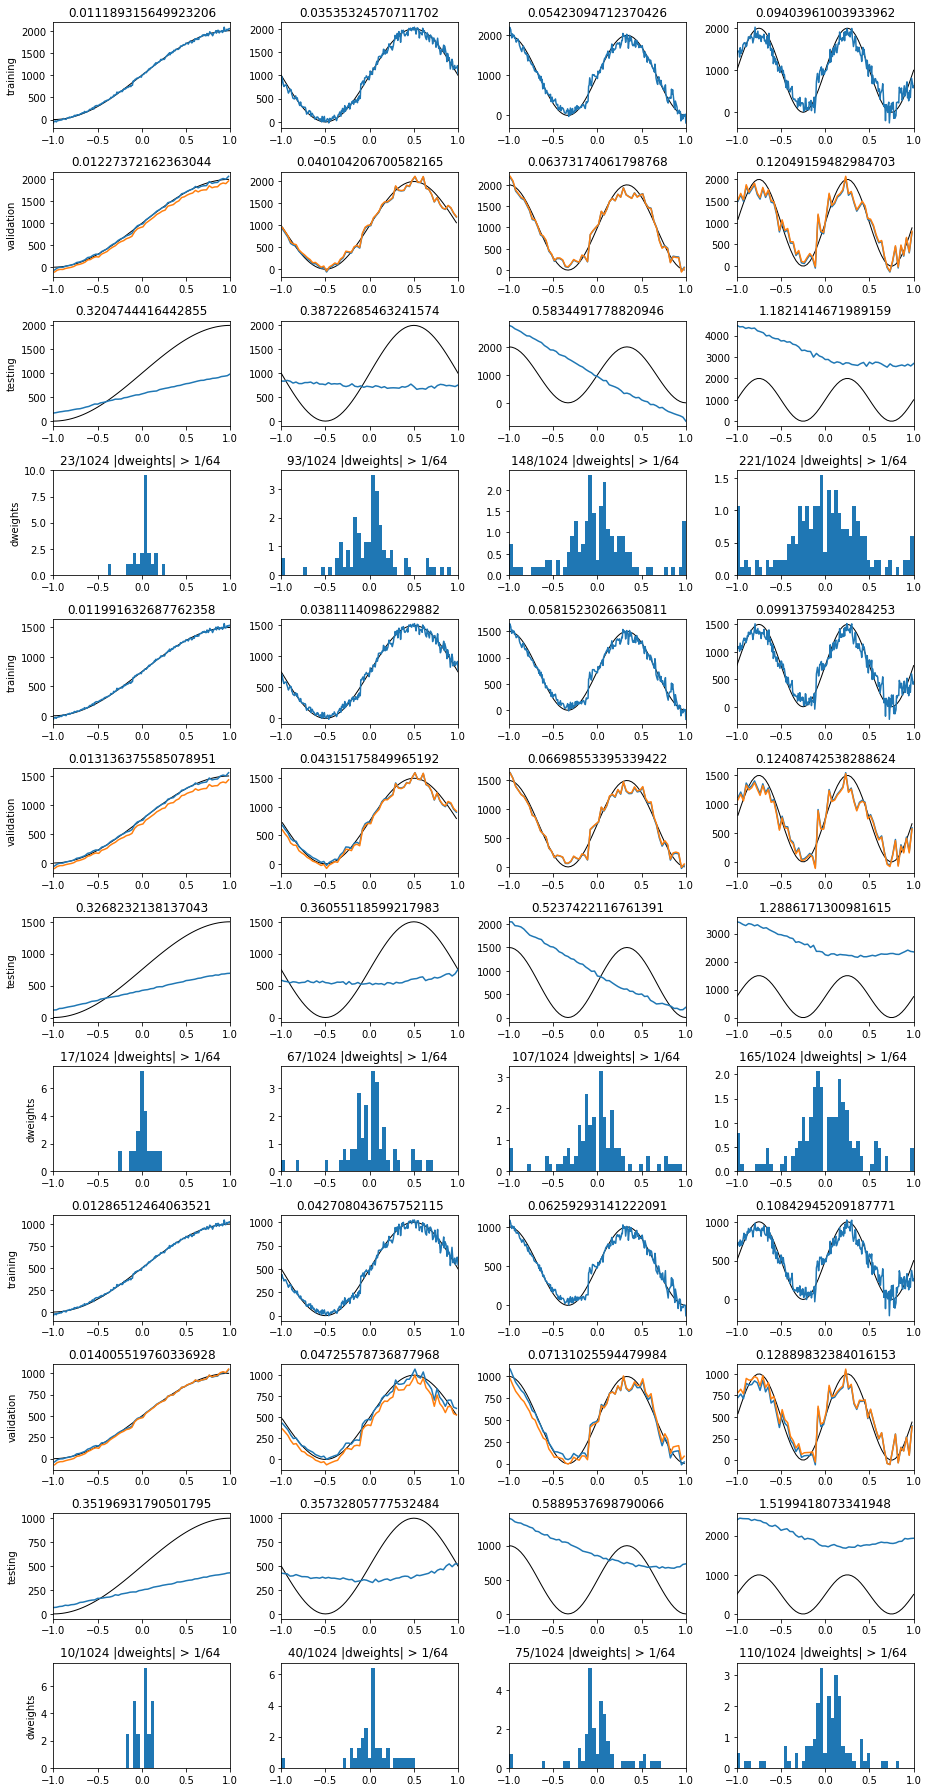

In [11]:
def check_plot_fits(exp_data):
    t_spike_rates = exp_data.training_spike_rates
    v_spike_rates = exp_data.validation_spike_rates
    
    t_input = exp_data.training_input_rates/exp_data.fmax_in
    v_input = exp_data.validation_input_rates/exp_data.fmax_in
    tst_input = exp_data.test_input_rates/exp_data.fmax_in
    
    exp_data.t_nrmse = np.zeros((len(exp_data.fmax_outs), len(exp_data.fcn_fs)))
    exp_data.v_nrmse = np.zeros_like(exp_data.t_nrmse)
    exp_data.vq_nrmse = np.zeros_like(exp_data.t_nrmse)
    exp_data.tst_nrmse = np.zeros_like(exp_data.t_nrmse)
    
    stim0_idx = np.argmin(np.abs(exp_data.tuning_input_rates)) # omit neurons that don't fire at 0
    spike_rates0 = exp_data.tuning_spike_rates[stim0_idx]
    nz_nrn0_idx = spike_rates0 > 0.
    
    hist_bins = np.linspace(-1, 1, 50)
    
    q_levels = 64
    q_res = 1/q_levels
    q_bins = np.hstack((-np.arange(q_levels+1)[::-1], np.arange(q_levels+1)[1:]))*q_res
    nrows = 4*len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3+1,nrows*2+1))
    if ncols==1:
        axs = np.array([axs]).T.tolist()
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            decoders = exp_data.decoders[idx0][idx1]
            q_idx = np.digitize(decoders-q_res/2, q_bins)
            q_decoders = q_bins[q_idx].reshape(decoders.shape)
            nz_decoders = decoders[np.logical_and(np.abs(decoders) >= 1/64, nz_nrn0_idx.reshape(-1, 1))]
            
            t_target = exp_data.training_targets[idx0][idx1]
            v_target = fmax_out * FCN(v_input, fcn_f)
            tst_target = fmax_out * FCN(tst_input, fcn_f)
            
            t_fit = np.dot(t_spike_rates, decoders)
            v_fit = np.dot(v_spike_rates, decoders)
            vq_fit = np.dot(v_spike_rates, q_decoders)
            tst_observed = exp_data.test_output_rates[idx0][idx1]
            
            t_nrmse = np.sqrt(np.mean((t_fit - t_target)**2))/fmax_out
            v_nrmse = np.sqrt(np.mean((v_fit - v_target)**2))/fmax_out
            vq_nrmse = np.sqrt(np.mean((vq_fit - v_target)**2))/fmax_out
            tst_nrmse = np.sqrt(np.mean((tst_observed - tst_target)**2))/fmax_out
            axs[idx0*4+0][idx1].plot(t_input, t_target,'k', linewidth=1)
            axs[idx0*4+0][idx1].plot(t_input, t_fit)
            axs[idx0*4+1][idx1].plot(v_input, v_target,'k', linewidth=1)
            axs[idx0*4+1][idx1].plot(v_input, v_fit)
            axs[idx0*4+1][idx1].plot(v_input, vq_fit)
            axs[idx0*4+2][idx1].plot(tst_input, tst_target,'k', linewidth=1)
            axs[idx0*4+2][idx1].plot(tst_input, tst_observed)
            axs[idx0*4+3][idx1].hist(nz_decoders, bins=hist_bins, density=True)
            
            axs[idx0*4+0][idx1].set_xlim([-1, 1])
            axs[idx0*4+1][idx1].set_xlim([-1, 1])
            axs[idx0*4+2][idx1].set_xlim([-1, 1])
            axs[idx0*4+3][idx1].set_xlim([-1, 1])
            axs[idx0*4+0][idx1].set_title("{}".format(t_nrmse))
            axs[idx0*4+1][idx1].set_title("{}".format(v_nrmse))
            axs[idx0*4+2][idx1].set_title("{}".format(tst_nrmse))
            axs[idx0*4+3][idx1].set_title("{}/{:d} |dweights| > 1/64 ".format(
                np.sum(np.abs(decoders)>=1/64), NNEURON))
            
            exp_data.t_nrmse[idx0, idx1] = t_nrmse
            exp_data.v_nrmse[idx0, idx1] = v_nrmse
            exp_data.vq_nrmse[idx0, idx1] = vq_nrmse
            exp_data.tst_nrmse[idx0, idx1] = tst_nrmse
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        axs[4*idx0+0][0].set_ylabel("training")
        axs[4*idx0+1][0].set_ylabel("validation")
        axs[4*idx0+2][0].set_ylabel("testing")
        axs[4*idx0+3][0].set_ylabel("dweights")
    plt.tight_layout()
    fig.savefig(FIG_DIR + "train_validate_test" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + "_L1_" + str(REG_L1) + "_L2_" + str(REG_L2) + "_fcn_f_" + str(FCN_F) + "_fmax_out_" + str(FMAX_OUTS) + ".png")
            
check_plot_fits(EXP_DATA)

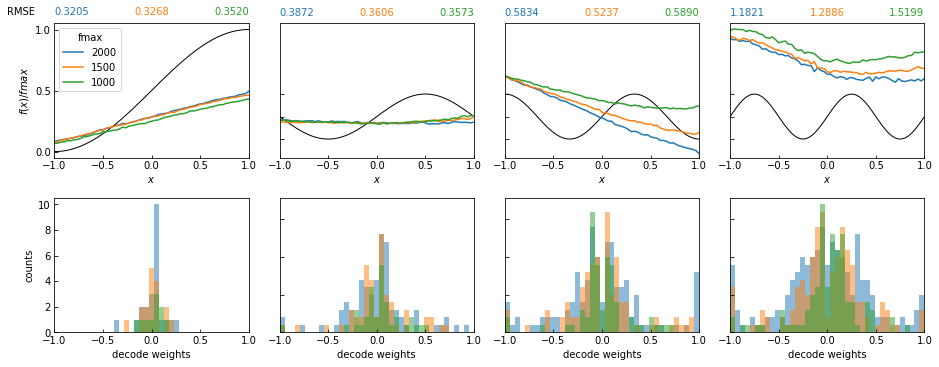

In [12]:
# plt.rc("text", usetex=True)
# plt.rc("font", "serif")

def plot_figure(exp_data):
    tst_input = exp_data.test_input_rates/exp_data.fmax_in
    
    stim0_idx = np.argmin(np.abs(exp_data.tuning_input_rates)) # omit neurons that don't fire at 0
    spike_rates0 = exp_data.tuning_spike_rates[stim0_idx]
    nz_nrn0_idx = spike_rates0 > 0.
    
    hist_bins = np.linspace(-1, 1, 40)
    
    nrows = 2
    ncols = len(exp_data.fcn_fs)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3+1,nrows*2+1))
    if ncols==1:
        axs = np.array([axs]).T.tolist()
    for idx1, fcn_f in enumerate(exp_data.fcn_fs):
        tst_target = FCN(tst_input, fcn_f)
        axs[0][idx1].plot(tst_input, tst_target, 'k', linewidth=1)
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            decoders = exp_data.decoders[idx0][idx1]
            nz_decoders = decoders[np.logical_and(np.abs(decoders) >= 1/64, nz_nrn0_idx.reshape(-1, 1))]
            axs[0][idx1].plot(tst_input, exp_data.test_output_rates[idx0][idx1]/fmax_out,
                              label="{:d}".format(fmax_out))
            axs[1][idx1].hist(nz_decoders, bins=hist_bins, alpha=0.5, label="{:d}".format(fmax_out))
    def set_axs_fmt(fig, axs, exp_data):
        ylim_mins = np.min(
            np.array([[axs[idx0][idx1].get_ylim()[0] for idx1 in range(len(exp_data.fcn_fs))]
                     for idx0 in range(2)]), axis=1)
        ylim_maxes = np.max(
            np.array([[axs[idx0][idx1].get_ylim()[1] for idx1 in range(len(exp_data.fcn_fs))]
                     for idx0 in range(2)]), axis=1)
        axs[0][0].tick_params(direction='in')
        axs[1][0].tick_params(direction='in')
        for idx0 in range(2):
            for idx1 in range(len(exp_data.fcn_fs))[1:]:
                axs[idx0][idx1].set_ylim(ylim_mins[idx0], ylim_maxes[idx0])
        for idx1 in range(len(exp_data.fcn_fs)):
            axs[0][idx1].set_yticks([0, 0.5, 1])
        for idx1 in range(len(exp_data.fcn_fs))[1:]:
            axs[0][idx1].set_yticklabels([])
            axs[1][idx1].set_yticklabels([])
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            ax_pos = axs[0][idx1].get_position()
            colors = [axs[0][idx1].get_lines()[idx0].get_color() for idx0 in range(1, len(exp_data.fmax_outs)+1)]
            ymax = axs[0][idx1].get_ylim()[1]
            axs[0][idx1].text(-1, 1.05*ymax, "{:.4f}".format(
                exp_data.tst_nrmse[0][idx1]), ha="left", va="bottom", color=colors[0])
            axs[0][idx1].text(0, 1.05*ymax, "{:.4f}".format(
                exp_data.tst_nrmse[1][idx1]), ha="center", va="bottom", color=colors[1])
            axs[0][idx1].text(1, 1.05*ymax, "{:.4f}".format(
                exp_data.tst_nrmse[2][idx1]), ha="right", va="bottom", color=colors[2])
            axs[0][idx1].set_xlabel(r"$x$")
            axs[1][idx1].set_xlabel("decode weights")
            axs[0][idx1].tick_params(direction='in')
            axs[1][idx1].tick_params(direction='in')
            axs[0][idx1].set_xlim([-1, 1])
            axs[1][idx1].set_xlim([-1, 1])
        axs[0][0].legend(loc="upper left", title="fmax")
        axs[0][0].set_ylabel(r"$f(x)/fmax$")
        axs[1][0].set_ylabel("counts")
    set_axs_fmt(fig, axs, exp_data)
    plt.tight_layout()
    fig.text(0, 1.01, "RMSE", ha="left", va="top")
    for fmt_str in ['.png', '.svg']:
        fig.savefig(FIG_DIR + "test_decode_weights" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + fmt_str)
            
plot_figure(EXP_DATA)

# Test Decoder Statistics

In [ ]:
def disable_neurons(y, x, disable_y, disable_x):
    for y_idx, x_idx in zip(range(y), range(x)):
        hal.driver.EnableSomaXY(0, x_idx, y_idx)
    print("disabling {:d} neurons".format(len(disable_y)))
    for y_idx, x_idx in zip(disable_y, disable_x):
        hal.driver.DisableSomaXY(0, x_idx, y_idx)
    hal.flush()

def run_raw_spikes_test(hal, run_control):
    """Run a single input test trial and collect the raw spikes"""
    test_time = 1
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns
    input_vals = {net.input:(input_times, input_rates)}
    
    _, spike_data = run_control.run_input_sweep(
        input_vals, get_raw_spikes=True, get_outputs=True)

    spikes, bin_times_ns = spike_data
    spikes = spikes[net.pool]
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return spikes, bin_times

def run_decoders_raw_spikes(exp_data, net, hal, run_control):
    """Test the output decode spike statistics"""
    hal.set_time_resolution(TESTING_RAW_SPIKES_DOWNSTREAM_NS, TESTING_RAW_SPIKES_UPSTREAM_NS)
    exp_data.raw_spikes = []
    exp_data.raw_spikes_bin_times = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.raw_spikes += [[]]
        exp_data.raw_spikes_bin_times += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            print("----------------------------------------------")
            print("Collecting raw spike data for fcn_f {} fmax_out {}".format(fcn_f, fmax_out))
            dweights = np.zeros((2, Y*X))
            net.decoder_conn.reassign_weights(dweights)
            hal.remap_weights()
            ##### # kill the neurons that have decode weights that will be clipped
            threshold = 1/8192 # finest possible precision
            # threshold = find_threshold(exp_data.decoders[idx0][idx1]) # actual precision
            disable_y, disable_x = np.nonzero((np.abs(exp_data.decoders[idx0][idx1])<threshold).reshape((Y, X)))
            disable_neurons(Y, X, disable_y, disable_x)
            #######
            raw_spikes, raw_spikes_bin_times = run_raw_spikes_test(hal, run_control)
            print("checking raw spikes")
            decode = utils.check_bins(raw_spikes)
            exp_data.raw_spikes[-1] += [raw_spikes]
            exp_data.raw_spikes_bin_times[-1] += [raw_spikes_bin_times]
            # check decode spikes
run_decoders_raw_spikes(EXP_DATA, net, hal, run_control)

----------------------------------------------
disabling 995 neurons
checking raw spikes
Collected 15666 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 102384334
                   1 : 15243
                   2 : 414
                   3 : 9
Sum(bins) = 16098
----------------------------------------------
disabling 923 neurons
checking raw spikes
Collected 32016 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 102367984
                   1 : 30298
                   2 : 1667
                   3 : 51
Sum(bins) = 33785
----------------------------------------------
disabling 867 neurons
checking raw spikes
Collected 45924 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 102354076
                   1 : 42441
                   2 : 3308
                   3 : 175
Sum(bins) = 49582
----------------------------------------------
disabling 794 neurons
checking raw spikes
Collected 65476 non-zero bins.
Bin stats (bin value : N b

In [ ]:
#  deliver an input of 0
def run_test(hal, run_control):
    """Run a single input test trial"""
    test_time = 1
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns

    input_vals = {net.input:(input_times, input_rates)}
    output_data, _ = run_control.run_input_sweep(
        input_vals, get_raw_spikes=False, get_outputs=True)

    outputs, bin_times_ns = output_data
    outputs = outputs[net.output]
    decode = outputs[:, 0]
    spikes = outputs[:, 1]
    
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return decode, spikes, bin_times

def run_decoders(exp_data, net, hal, run_control):
    """Test the output decode spike statistics"""
    hal.set_time_resolution(TESTING_DOWNSTREAM_NS, TESTING_UPSTREAM_NS)
    exp_data.decodes = []
    exp_data.spikes = []
    exp_data.bin_times = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.decodes += [[]]
        exp_data.spikes += [[]]
        exp_data.bin_times += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            print("----------------------------------------------")
            print("Collecting decode and total spike data for fcn_f {} fmax_out {}".format(fcn_f, fmax_out))
            decoders = exp_data.decoders[idx0][idx1].flatten()
            dweights = np.ones((2, Y*X))
            dweights[0] = decoders
            dweights[1][decoders<1/64] = 0
            net.decoder_conn.reassign_weights(dweights)
            hal.remap_weights()
            decode, spikes, bin_times = run_test(hal, run_control)
            print("checking decoded-weighted spikes")
            decode = utils.check_bins(decode)
            print("checking summed spikes")
            spikes = utils.check_bins(spikes)
            exp_data.decodes[-1] += [decode]
            exp_data.spikes[-1] += [spikes]
            exp_data.bin_times[-1] += [bin_times]
            # check decode spikes
run_decoders(EXP_DATA, net, hal, run_control)

In [ ]:
def analyze_decodes(exp_data):
    exp_data.fin = []
    exp_data.fout = []
    exp_data.mean = []
    exp_data.snr = []
    exp_data.raw_snr = [] # snr of decode weights applied to raw spikes

    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.fin += [[]]
        exp_data.fout += [[]]
        exp_data.mean += [[]]
        exp_data.snr += [[]]
        exp_data.raw_snr += [[]]

        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            # decode data and total fin spikes
            bin_times = exp_data.bin_times[idx0][idx1]
            decode = exp_data.decodes[idx0][idx1]
            spikes = exp_data.spikes[idx0][idx1]
            # filter decode
            dt = bin_times[1] - bin_times[0]
            filtered_spikes = lpf(spikes, TAU_READOUT, dt)
            filtered_decode = lpf(decode, TAU_READOUT, dt)
            # raw spikes
            raw_spikes_bin_times = exp_data.raw_spikes_bin_times[idx0][idx1]
            raw_spikes = exp_data.raw_spikes[idx0][idx1]
            decoded_raw_spikes = np.dot(raw_spikes, exp_data.decoders[idx0][idx1])
            # process raw spikes
            dt_raw_spikes = raw_spikes_bin_times[1] - raw_spikes_bin_times[0]
            filtered_decoded_raw_spikes = lpf(decoded_raw_spikes, TAU_READOUT, dt_raw_spikes)
            
            idx = bin_times>CLIP_TIME
            fin = np.sum(spikes[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
            fout = np.sum(decode[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
            mean = np.mean(filtered_decode[idx])
            var = np.var(filtered_decode[idx])
            snr = mean/np.sqrt(var)
            raw_mean = np.mean(filtered_decoded_raw_spikes)
            raw_var = np.var(filtered_decoded_raw_spikes)
            raw_snr = raw_mean/np.sqrt(raw_var)
            info_str = "fmax_out {:4d} fcn_f {:.1f} expected mean {:4.0f} ".format(fmax_out, fcn_f, fmax_out/2)
            info_str += "fin {: 6.0f} mean {:6.0f} ({:6.0f}) var {:8.0f} ({:8.0f}) snr {:5.2f} ({:5.2f})".format(
                fin, mean, raw_mean, var, raw_var, snr, raw_snr)
            print(info_str)
            exp_data.fin[-1] += [fin]
            exp_data.fout[-1] += [fout]
            exp_data.mean[-1] += [mean]
            exp_data.snr[-1] += [snr]
            exp_data.raw_snr[-1] += [raw_snr]

analyze_decodes(EXP_DATA)

In [ ]:
def plot_decode_output(exp_data, tau):
    # plot filtered decodes and spikes out
    fin = np.array(exp_data.fin)
    fout = np.array(exp_data.fout)
    
    nrows = len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig_filt, axs_filt = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                                      figsize=(ncols*3+1, nrows*2+1))
    fig_filt_fout, axs_filt_fout = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,
                                      figsize=(ncols*3+1, nrows*2+1))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][2:]
    len_c = len(colors)
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            
            # decode data and total fin spikes
            bin_times = exp_data.bin_times[idx0][idx1]
            decode = exp_data.decodes[idx0][idx1]
            spikes = exp_data.spikes[idx0][idx1]
            # filter decode
            dt = bin_times[1] - bin_times[0]
            filtered_spikes = lpf(spikes, TAU_READOUT, dt)
            filtered_decode = lpf(decode, TAU_READOUT, dt)
            # raw spikes
            raw_spikes_bin_times = exp_data.raw_spikes_bin_times[idx0][idx1]
            raw_spikes = exp_data.raw_spikes[idx0][idx1]
            decoded_raw_spikes = np.dot(raw_spikes, exp_data.decoders[idx0][idx1])
            # process raw spikes
            dt_raw_spikes = raw_spikes_bin_times[1] - raw_spikes_bin_times[0]
            filtered_decoded_raw_spikes = lpf(decoded_raw_spikes, TAU_READOUT, dt_raw_spikes)
            
            fin = exp_data.fin[idx0][idx1]
            fout = exp_data.fout[idx0][idx1]
            mean = exp_data.mean[idx0][idx1]

            ax = axs_filt[idx0][idx1]
            ax.axhline(fin, color="k", alpha=0.5)
            ax.axhline(fout, color="k", alpha=0.5)
            ax.plot(bin_times, filtered_spikes)
            ax.plot(bin_times, filtered_decode)
            ax.plot(raw_spikes_bin_times, filtered_decoded_raw_spikes)
            
            ax = axs_filt_fout[idx0][idx1]
            ax.axhline(fout, color="k", alpha=0.5)
            ax.plot(bin_times, filtered_decode)
            ax.plot(raw_spikes_bin_times, filtered_decoded_raw_spikes)
    for idx1, fcn_f in enumerate(exp_data.fcn_fs):
        axs_filt[0][idx1].set_title("fmax*(sin({:.1f}*pi*x)/2+0.5)".format(fcn_f))
        axs_filt[-1][idx1].set_xlabel("Time (s)")
    plt.tight_layout()
    fig_filt.savefig(FIG_DIR + "accumulator_filt" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + ".png")
plot_decode_output(EXP_DATA, TAU_READOUT)

In [ ]:
def plot_decode_stats(exp_data, tau):
    # plot on gamma plot
    fin = np.array(exp_data.fin)
    fout = np.array(exp_data.fout)
    ylim_min = 10**(int(np.log10(np.min(exp_data.snr))))
    xlim_min = 10**(int(np.log10(fout.min())))*tau
    fend = np.array([xlim_min/tau, fin.max()])
    fout_plot = np.logspace(np.log10(fend[0]), np.log10(fend[1]))
    
    nrows = len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig_snr, ax_snr = plt.subplots(figsize=(8, 6))

    snr_per = utils.get_snr_periodic(fout_plot*tau)
    snr_per_high_lt_appx = np.sqrt(12)*fend*tau
    snr_poi = np.sqrt(2*fend*tau)
    ax_snr.loglog(fout_plot*tau, snr_per, "k", linewidth=1)
    ax_snr.loglog(fend*tau, snr_per_high_lt_appx, "k", linewidth=1, alpha=0.2)
    ax_snr.loglog(fend*tau, snr_poi, "k", linewidth=1)
    
    k_max = np.max(fin/fout)
    
    k_plt = np.logspace(0, int(np.log2(k_max))+4, 100)
    fin_max = np.max(fin)
    fin_min = np.min(fin)
    fout_max = fin_max / k_plt
    fout_min = fin_min / k_plt
    snr_gamma_max = utils.get_snr_gamma_approx(fout_max*tau, k_plt)
    snr_gamma_min = utils.get_snr_gamma_approx(fout_min*tau, k_plt)
    ylim_max = 10**(int(np.log10(np.max(snr_gamma_max)))+1)
    ylim_min = 10**(int(np.log10(np.min(exp_data.snr))))
    ax_snr.loglog(fout_max*tau, snr_gamma_max, 'k', alpha=0.5)
    ax_snr.loglog(fout_min*tau, snr_gamma_min, 'k', alpha=0.5)
    # ax_snr.fill_between()

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][2:]
    len_c = len(colors)
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            bin_times = exp_data.bin_times[idx0][idx1]
            fin = exp_data.fin[idx0][idx1]
            fout = exp_data.fout[idx0][idx1]
            mean = exp_data.mean[idx0][idx1]
            snr = exp_data.snr[idx0][idx1]
            raw_snr = exp_data.raw_snr[idx0][idx1]

            k_eff = fin/fout
            snr_th = utils.get_snr_gamma_approx(fout*tau, k_eff)
            if idx0 == 0:
                label_t = "predicted snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
                label_acc_in = "est acc in snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
                label_o = "observed  snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
            else:
                label_o = None
                label_acc_in = None
                label_t = None
            ax_snr.loglog(fout*tau, snr_th, 'o', color=colors[idx1%len_c], fillstyle='none', label=label_t)
            ax_snr.loglog(fout*tau, raw_snr, '+', color=colors[idx1%len_c], fillstyle='none', label=label_acc_in)
            ax_snr.loglog(fout*tau, snr, 'o', color=colors[idx1%len_c], label=label_o)
    lgd = ax_snr.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    
    ax_snr.set_xlim((xlim_min, fin_max*tau))
    ax_snr.set_ylim((ylim_min, ylim_max))
    ax_snr.set_xlabel("f_out * tau")
    ax_snr.set_ylabel("SNR")
    ax_snr.grid(which="both")
    fig_snr.savefig(FIG_DIR + "snr" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + ".png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plot_decode_stats(EXP_DATA, TAU_READOUT)